# **BMEN 4470 - Deep Learning for Biomedical Signal Processing**
# **Homework 2: Basics of Modeling Sequences and Temporal Convolution Networks**

Due 11:59pm on October 16th, 2023

Please include the names of people you've collaborated with here:

In [61]:
#%pip install bunch
#Import
import sys
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import scipy.io as sio
from bunch import Bunch
import torch.optim as optim
from pandas import DataFrame
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils import weight_norm
from os.path import dirname, join as pjoin
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

**Problem 1: ARMA Model** In this question, you need to apply three different Autoregressive Moving Average Model (ARMA) to the given EKG signal. Compare the input and output signals and answering the following questions. 

In [62]:
# The EGK signal contains 100 data points
EKG_sig = [41.985077,48.505554,17.868908,-17.902781,-25.676805,2.4074743,40.308300,50.589020,22.663403,-16.953960,-32.144905,-31.155527,-23.732307,6.5244060,44.417355,58.700817,60.295696,58.277584,51.427200,24.971256,18.454710,42.659885,28.012609,13.741727,14.357091,15.576780,11.927580,-14.444111,-25.185453,-19.081909,6.6035562,17.284658,17.544495,16.928368,-6.3161540,-14.990187,10.754345,21.378378,-3.1653652,-13.225622,15.521652,54.976814,64.869339,35.326790,-5.0551395,-18.008286,-15.629535,-11.389389,15.224802,52.611454,69.125626,71.429947,69.159081,63.929958,35.759071,-1.0452937,-12.551209,9.9472542,23.483477,29.982676,53.127209,38.299618,26.093702,25.454752,0.92754990,-9.3693218,19.490158,56.732342,40.379166,1.2176796,15.432666,53.198875,38.633102,1.4428799,12.662603,25.239782,24.835445,19.891754,-6.5586896,3.0409441,15.515370,13.531504,6.8291478,-15.963812,0.38266551,33.888634,14.340966,-27.637432,-37.876808,-12.587003,-1.4763706,-1.0964720,20.268143,5.8535609,-29.653194,-16.162226,18.147284,6.5141749,-4.5157704,13.640582]

**1(a)** Moving Average model only

/Users/lawr_xd/anaconda3/envs/BMENE4470/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


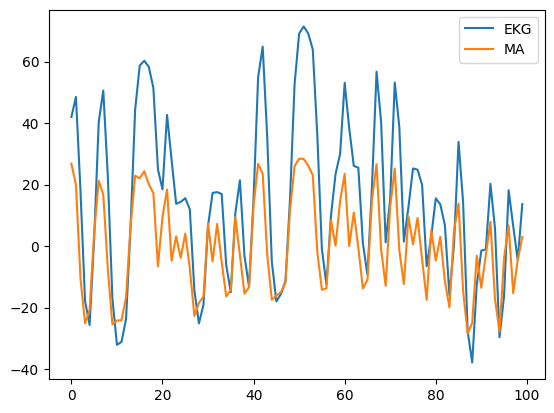

In [63]:
model_1 = ARIMA(EKG_sig, order=[0, 0, 1])# put the order here
model_fit_1 = model_1.fit()
residuals_1 = DataFrame(model_fit_1.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_1, label='MA')
plt.legend()
plt.show()

**1(b)** Autoregressive model only

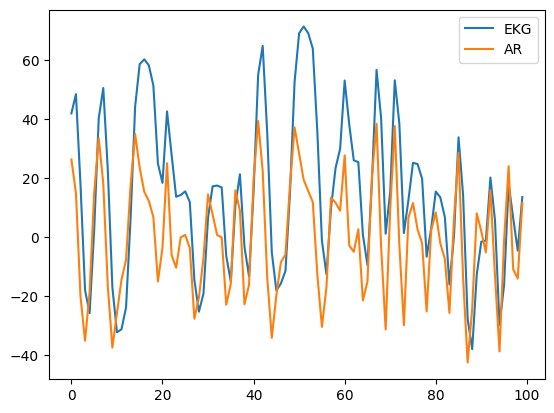

In [45]:
model_2 = ARIMA(EKG_sig, order=[1, 0, 0])# put the order here
model_fit_2 = model_2.fit()
residuals_2 = DataFrame(model_fit_2.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_2, label='AR')
plt.legend()
plt.show()

**1(c)** ARMA model with p = 5, q = 1

/Users/lawr_xd/anaconda3/envs/BMENE4470/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


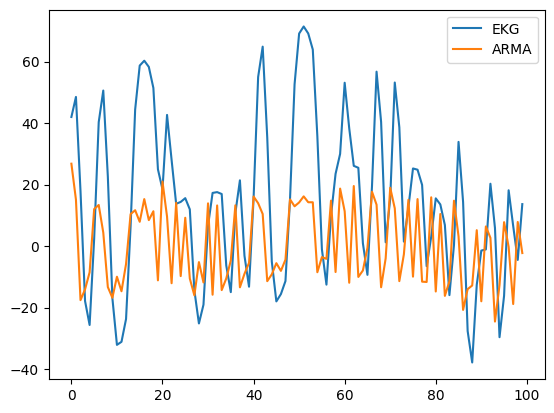

In [44]:
model_3 = ARIMA(EKG_sig, order=[5, 0, 1])# put the order here
model_fit_3 = model_3.fit()
residuals_3 = DataFrame(model_fit_3.resid)

# line plot of the results
plt.plot(EKG_sig, label='EKG')
plt.plot(residuals_3, label='ARMA')
plt.legend()
plt.show()

**1(d)** What are the differences between those three models? Which model works best for this EKG data? What are the pros and cons of each model? Please list at least one pro and con for each model. 

Your Answers:
- From Observation, the Moving Average Model was able to predict the same shape of the EKG data, showing that it's able to predict the relative amplitude of each data point. 
- The auto regressive model has a larger amplitude on the predictions, but shows significantly more lag when the sign changes for the data. 
- The ARMA model had the worst predictions of them all. There seems to be an onvercompensation of the lag for the predction. 

- The moving average model is best at minimizing or eliminating the errors for the data prediction. 
- The Auto Regressive model is better at matching trends. For example if the data is trending upwards or downwards, it's better at predicting the correct results. 
- the ARMA model was able to show both, but with the given parameters it might be overcompensating. 

**Problem 2 Temporal Convolutional Networks** In this question, we will generate a dataset and build a simple TCN to train and test on the dataset. 

This dataset contains some data sequences: a pair of input sequences and an output. The first sequence within the input pair is composed of numbers randomly sampled from the range [0, 1]. The second input sequence within the input pair is composed of only integers: 0 or 1. This sequence must contain only two integer 1; the rest of the integers are all 0s. The output is the sum of the two values from the first input sequence corresponding to 1s in the second input sequence. 

For example, one input sequence pair can be [[0, 0.1, 0.2, 0.3, 0.4, 0.5], [0, 0, 0, 1, 1, 0]]. In this case, the final output value should be 0.3 + 0.4 = 0.7. In this example, the length of the data sequence is 6.

For the detail of TCN, see the GitHub repo [here](https://github.com/locuslab/TCN/tree/master/TCN/adding_problem).

In [64]:
# data generator
def data_generator(N, seq_length):
    """
    Args:
        seq_length: Length of the adding problem data
        N: # of data in the set
    """
    X_num = torch.rand([N, 1, seq_length])
    X_mask = torch.zeros([N, 1, seq_length])
    Y = torch.zeros([N, 1])
    for i in tqdm(range(N)):
        positions = np.random.choice(seq_length, size=2, replace=False)
        X_mask[i, 0, positions[0]] = 1
        X_mask[i, 0, positions[1]] = 1
        Y[i,0] = X_num[i, 0, positions[0]] + X_num[i, 0, positions[1]]
    X = torch.cat((X_num, X_mask), dim=1)
    return Variable(X), Variable(Y)

In [65]:
# generate data
X_train, Y_train = data_generator(5000, 100)
X_test, Y_test = data_generator(100, 100)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 37233.06it/s]


In [66]:
# define several classes for training.
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [94]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


**2(a)** Build your TCN model below. Your model should contain two convolutional layers.

In [95]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Your Code:
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

**2(b)** Set and adjust the training parameters to make the Average Difference you got from your network smaller than 0.008. 

In [96]:
# initialize training parameters.
args = Bunch()
# adjustable parameters
args.epochs = 100# put values here
args.ksize = 15# put values here
args.batch_size = 2# put values here
args.lr = 1# put values here

# fix parameters
#args.cuda = False
args.dropout = False
args.seq_len = 100
args.clip = -1
args.levels = 8
args.log_interval = 100
args.optim = 'Adam'
args.nhid = 30
args.seed = 112


Train your model. You need to use GPU for training here. To start a GPU on your Colab, follow the instruction on the slides for this assignment. Please re-run the first block after you set up the GPU. 

In [97]:
# train the model with two conv layers
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


def train(epoch):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size)], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)
        loss = F.mse_loss(output, y)
        loss.backward()
        if args.clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % args.log_interval == 0:
            cur_loss = total_loss / args.log_interval
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate():
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nValidation set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

AttributeError: cuda

In [ ]:
# show the results. You will get full credit if the average differences is less than 0.02
preds = model(X_test)

total_diff = 0
for i,pred in enumerate(preds):
    total_diff += np.abs(pred.data.item() - Y_test[i].item())


print('Average Difference:', total_diff/len(Y_test))

**2(c)** Now build a TCN model with only one convolutional layer. Use the same parameter you set in 2(b) and train your network.

In [ ]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Your Code:


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# train the model with two conv layers
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

input_channels = 2
n_classes = 1
batch_size = args.batch_size
seq_length = args.seq_len
epochs = args.epochs


# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [args.nhid]*args.levels
kernel_size = args.ksize
dropout = args.dropout
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size, dropout=dropout)

if args.cuda:
    model.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    X_test = X_test.cuda()
    Y_test = Y_test.cuda()

lr = args.lr
optimizer = getattr(optim, args.optim)(model.parameters(), lr=lr)


for ep in range(1, epochs+1):
    train(ep)
    tloss = evaluate()

# show the result
preds = model(X_test)

total_diff = 0
for i,pred in enumerate(preds):
    total_diff += np.abs(pred.data.item() - Y_test[i].item())


print('Average Difference:', total_diff/len(Y_test))

**2(d)** Compare the result you get from 2(c) with the average difference you get from 2(b). Which network gives you a better result? Why that network gives a better result? Do you have any suggestions to improve the performance of the network that has poorer performance? 

Your Answers:

**Problem 3: EEGNet** In this question, we will use EEGNet, a compact convolutional network for EEG-based brain-computer interfaces. Your task is to process the given EEG data so that you can train and test the network on the dataset. For more detail about the EEGNet, please see the GitHub repo here:
https://github.com/aliasvishnu/EEGNet.

The EEG data given in this question are generated. Feel free to print or plot the data if you want to know what the dataset looks like. 



In [ ]:
# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/drive', force_remount=True)

In [ ]:
# Import data and save as np.array
Data = sio.loadmat('PATH/TO/FILE/X.mat')
Label = sio.loadmat('PATH/TO/FILE/Y.mat')
Dataset = Data['Data']
Labels = Label['Labels']
print(Dataset.shape, Labels.shape)

In [ ]:
# define the EEGNet
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 120
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))

        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # here we have 120 timepoints
        self.fc1 = nn.Linear(4*2*7, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1, 4*2*7)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
# Define the evaluation function
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 50
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
    return results

**3(a)** Now, reshape the data so you can train it using EEGNet. To train the network, you also need to modify the network parameters to match the dimension of your training data. Please see the image [here](https://github.com/aliasvishnu/EEGNet/blob/master/EEGNet.png) for more information. 

In [ ]:
 # Your coode
X = 
Y = 
print(X.shape, Y.shape)

**3(b)** Now split the training, evaluation, and testing data. Please make sure you have about 80% for training, about 10% for evaluation, and about 10% for testing. Then train your network on the dataset and test it.

In [ ]:
# Your Code: 
# Please name the parameters as names given below in the print function.
X_train = 
y_train = 

X_val = 
y_val = 

X_test = 
y_test = 

print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


In [ ]:
# train and test on your dataset
batch_size = 16

for epoch in range(40):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc"]
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))



In [ ]:
# print test accuracy
print("Test - ", evaluate(net, X_test, y_test, params))

**3(c)** Now, split the data by 50% training, 40% validation, 10% testing, and retrain your model.

In [ ]:
# Your Code:
X_train = 
y_train = 

X_val = 
y_val = 

X_test = 
y_test = 

print(X_train.shape, X_val.shape,X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

In [ ]:
# train and test on the dataset with 50% training, 40% validation, and 10% test data
batch_size = 16

for epoch in range(40):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size-1)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)   
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))
    print("Validation - ", evaluate(net, X_val, y_val, params))


In [ ]:
print("Test - ", evaluate(net, X_test, y_test, params))

**3(d)** Compare the result you get from 3(d) with the test accuracy in 3(c). Which data split method gives you a better result? Why that method gives a better result? What did you learn from this?

Your Answers: